# Analyzing Call Targets

## Setup

In [1]:
# Load libraries

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from typing import *

%config InlineBackend.figure_format='png'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Configure pyplot: enlarge plots
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pyplot: set larger font
plt.rcParams.update({'font.size': 10})
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

# monospace font
monospace = fm.FontProperties(family='monospace')

In [2]:
all_calls = pd.read_csv(
    "resolved-calls/cross_crate_calls.csv",
    names=[
        "receiver",
        "receiver_generics",
        "target",
        "target_type_generics",
        "target_function_generics",
        "caller_crate",
        "target_crate",
        "macro",
        "count",
    ],
    sep=",",
    keep_default_na=False,
    dtype=str,
)
all_calls["count"] = all_calls["count"].astype(int)


In [3]:
all_calls.sort_values(by="count", ascending=False)

,receiver,receiver_generics,target,target_type_generics,target_function_generics,caller_crate,target_crate,macro,count
224858,,,quote::__private::push_ident,,,serde_derive,quote,quote::quote,63393
14881389,F,,core::ops::function::FnMut::call_mut,(&T),,partition_point_veb_layout,core,,48510
68345,T,,core::default::Default::default,,,tinyvec,core,,43450
214020,,,libsecp256k1_core::field::FieldStorage::new,,,libsecp256k1,libsecp256k1_core,,34816
13330649,F,,core::ops::function::FnMut::call_mut,(usize),,unroll_fn,core,,32896
3734646,,,core::fmt::Formatter::write_str,,,unicode_types,core,core::fmt::macros::Debug,32705
8612716,usize,,core::clone::Clone::clone,,,pseudotex,core,,31560
224251,,,quote::__private::push_colon2,,,serde_derive,quote,quote::quote,28197
2653753,,,core::fmt::Formatter::write_str,,,opcua_types,core,core::fmt::macros::Debug,27944
1440175,,,sp_weights::weight_v2::Weight::saturating_add,,,frame_support,sp_weights,,25228


In [4]:
# combine entries past a certain rank into "x others", expecting them to be sorted
def cut_off_after_top(count: int, counts: pd.DataFrame) -> pd.DataFrame:
	trimmed = counts[:count].copy()
	dropped_count = len(counts) - count
	total = counts['count'].sum()
	trimmed.loc[f"{dropped_count} others"] = total - trimmed['count'].sum()
	return trimmed

In [5]:
# group by the given columns, summing the counts for any combined entries
def sum_counts(frame, columns: List[str]) -> pd.DataFrame:
	frame = frame.groupby(columns)['count'].sum().sort_values(ascending=False).to_frame()
	frame.reset_index(inplace=True)
	return frame

In [6]:
sum_counts(all_calls, ["caller_crate"])

,caller_crate,count
0,syn,596378
1,fhir,318963
2,serde_derive,223777
3,gcp_client,194165
4,aws_sdk_ec2,182631
5,steam_vent_proto,179026
6,tikv_client_proto,169366
7,tokio,164675
8,df_ls_structure,158412
9,cfn,156433


In [7]:
from_calls = all_calls[all_calls['target'] == 'core::convert::From::from']
from_counts = sum_counts(from_calls, ['target_type_generics', 'receiver', 'receiver_generics', 'macro'])
print("from() calls:", from_counts["count"].sum())

from_counts = from_counts.rename(columns={
	'target_type_generics': 'source',
	'receiver': 'target',
	'receiver_generics': 'target_generics',
})
from_counts['source_generics'] = ""

into_calls = all_calls[all_calls['target'] == 'core::convert::Into::into']
into_counts = sum_counts(into_calls, ['target_type_generics', 'receiver', 'receiver_generics', 'macro'])
print("into() calls:", into_counts["count"].sum())

into_counts = into_counts.rename(columns={
	'target_type_generics': 'target',
	'receiver': 'source',
	'receiver_generics': 'source_generics',
})
into_counts['target_generics'] = ""

all_conversions = sum_counts(pd.concat([from_counts, into_counts]), ['source', 'source_generics', 'target', 'target_generics', 'macro'])

conversions = all_conversions.copy()
print("calls incl. macros:", conversions["count"].sum())
conversions.drop(conversions[conversions['macro'] != ''].index, inplace=True)
conversions.drop(columns=['macro'], inplace=True)
print("calls excl. macros:", conversions["count"].sum())
conversions.drop(conversions[conversions['source'].str.startswith('impl ')].index, inplace=True)
conversions.drop(conversions[conversions['source'].str.len() == 1].index, inplace=True)
print("calls excl. known unspecifiable:", conversions["count"].sum())
conversions.reset_index(drop=True, inplace=True)

conversions.loc[:20]

from() calls: 659319
into() calls: 1112335
calls incl. macros: 1771654
calls excl. macros: 1397403
calls excl. known unspecifiable: 1139206


,source,source_generics,target,target_generics,count
0,&str,,alloc::string::String,,147264
1,proc_macro2::TokenStream,,proc_macro::TokenStream,,16328
2,aws_smithy_types::error::Error,,alloc::boxed::Box<dyn std::error::Error + std:...,,12328
3,aws_types::region::Region,,aws_types::region::SigningRegion,,12263
4,&str,,alloc::borrow::Cow<str>,,11818
5,alloc::string::String,,hyper::body::body::Body,,11656
6,[f32],,geometric_algebra::simd::Simd32x4,,9666
7,aws_smithy_http::body::SdkBody,,aws_smithy_http::body::SdkBody,,9320
8,alloc::string::String,,aws_smithy_http::body::SdkBody,,9213
9,f32,,geometric_algebra::simd::Simd32x4,,9016


In [8]:
pin_calls = all_calls[all_calls['target'] == 'core::pin::Pin<P>::new_unchecked']
pin_counts = sum_counts(pin_calls, ['target_type_generics', 'caller_crate'])

for pin_generics, caller_crate, count in pin_counts.values[:10]:
	print(f"{count}x Pin<{pin_generics}>::new from {caller_crate}")

10252x Pin<&core::pin::Pin<alloc::boxed::Box<dyn std::future::Future<Output = std::result::Result<(), Error>> + std::marker::Send>>>::new from sp_inherents
10230x Pin<&core::pin::Pin<alloc::boxed::Box<dyn std::future::Future<Output = std::option::Option<std::result::Result<(), Error>>> + std::marker::Send>>>::new from sp_inherents
2588x Pin<&core::marker::PhantomPinned>::new from tokio
2200x Pin<&St>::new from futures_util
1716x Pin<&hyper::client::client::ResponseFuture>::new from jinxapi_github
1392x Pin<&core::option::Option<Fut>>::new from futures_util
1334x Pin<&impl std::future::Future<Output = std::result::Result<(), <T as tonic::client::GrpcService<tonic::body::BoxBody>>::Error>>>::new from gcp_client
1283x Pin<&impl std::future::Future<Output = std::string::String>>::new from google_compute1
1149x Pin<&R>::new from tokio
1011x Pin<&W>::new from tokio


In [45]:
size_of_calls = all_calls[all_calls['target'] == 'core::mem::size_of']
size_of_counts = sum_counts(size_of_calls.rename(columns={'target_function_generics': 'type'}), ['type'])

print(f"total: {size_of_counts['count'].sum()}")
size_of_counts.drop(size_of_counts[size_of_counts['type'].str.isupper()].index, inplace=True)
size_of_counts.reset_index(drop=True, inplace=True)
print(f"total excl. known unspecifiable: {size_of_counts['count'].sum()}")
size_of_counts.loc[:20]

total: 100635
total excl. known unspecifiable: 89218


,type,count
0,u32,9920
1,u8,8048
2,u64,7369
3,u16,6046
4,usize,4987
5,i32,4974
6,i64,3978
7,i16,3703
8,u128,3348
9,i128,2939


In [10]:
with open("known_sizes.txt") as f:
	known_size_types = set(line.strip() for line in f.readlines())

known = size_of_counts[size_of_counts['type'].isin(known_size_types)]['count'].sum()
total = size_of_counts['count'].sum()
print(f"size_of calls specified: {known} / {total} ({known / total * 100:.2f}%)")

size_of calls specified: 65109 / 89218 (72.98%)


In [37]:
index_calls = all_calls[all_calls['target'] == 'core::ops::index::Index::index']
index_counts = sum_counts(index_calls, ['target_type_generics'])

print(f"total: {index_counts['count'].sum()}")
for type, count in sum_counts(index_calls, ['target_type_generics']).values[:10]:
	print(f"{count}x index with {type}")

total: 656335
310985x index with usize
85411x index with core::ops::range::RangeFull
81259x index with core::ops::range::RangeFrom<usize>
76192x index with core::ops::range::Range<usize>
42396x index with core::ops::range::RangeTo<usize>
19626x index with &str
4722x index with (usize, usize)
2673x index with core::ops::range::RangeInclusive<usize>
1531x index with &[usize]
1484x index with [usize]


In [38]:
for receiver, count in sum_counts(index_calls, ['receiver']).values[:10]:
	print(f"{count}x index on {receiver}")

271669x index on alloc::vec::Vec
79912x index on [u8]
47798x index on str
26487x index on alloc::string::String
13635x index on geometric_algebra::simd::Simd32x4
9601x index on serde_json::value::Value
8471x index on std::collections::hash::map::HashMap
7632x index on ark_ff::const_helpers::MulBuffer
7339x index on geometric_algebra::simd::Simd32x3
6407x index on ndarray::ArrayBase


In [49]:
with open("known_defaults.txt") as f:
	known_default_types = set(line.strip() for line in f.readlines())

default_calls = all_calls[all_calls['target'] == 'core::default::Default::default']
default_counts = sum_counts(default_calls, ['receiver'])

print(f"total: {default_counts['count'].sum()}")
default_counts.drop(default_counts[default_counts['receiver'].str.isupper()].index, inplace=True)
default_counts.reset_index(drop=True, inplace=True)
print(f"total excl. known unspecifiable: {default_counts['count'].sum()}")

known = default_counts[default_counts['receiver'].isin(known_default_types)]['count'].sum()
total = default_counts['count'].sum()
print(f"default calls specified: {known} / {total} ({known / total * 100:.2f}%)")

default_counts['specified'] = default_counts['receiver'].isin(known_default_types)
default_counts.loc[:20]


total: 1900443
total excl. known unspecifiable: 1824804
default calls specified: 1108560 / 1824804 (60.75%)


,receiver,count
0,core::option::Option,724081
1,alloc::vec::Vec,112272
2,alloc::string::String,92479
3,bool,39835
4,schemars::schema::Metadata,31099
5,std::collections::hash::map::HashMap,28338
6,u32,26611
7,aws_smithy_types::error::Error,23676
8,schemars::schema::SchemaObject,18593
9,(),18087


---

# Progress Tracking

In [14]:
progress_csv = (
    pd.read_csv(
        "spec_progress.csv",
        header=0,
        index_col=False,
        names=["receiver", "target", "reason"],
        dtype=str,
        comment="#",
    )
    .dropna(how="all")
	.fillna("")
)
progress_csv

,receiver,target,reason
0,core::result::Result,core::ops::try_trait::Try::branch,
1,core::result::Result,core::ops::try_trait::FromResidual::from_residual,
2,core::option::Option,core::ops::try_trait::Try::branch,
3,core::option::Option,core::ops::try_trait::FromResidual::from_residual,
4,*,core::clone::Clone::clone,
5,T,core::default::Default::default,
6,,core::option::Option<T>::is_some,
7,,core::option::Option<T>::is_none,
8,,core::option::Option<T>::as_ref,refs
9,,core::option::Option<T>::as_mut,refs


In [15]:
progress = {}
used_progress = set()

for (receiver, call_target, reason) in progress_csv.values:
	if not call_target: continue
	key = (receiver, call_target)
	if key in progress:
		raise Exception(f"Duplicate entry for {key}")
	progress[key] = reason

def _get_progress(receiver: str, call_target: str, macro: str) -> Optional[str]:
	key = (receiver, call_target)
	try:
		result = progress[key]
		used_progress.add(key)
		return result or "complete"
	except KeyError:
		if macro:
			return "macro"
		else:
			return None

# if incomplete, returns string listing future features necessary for complete specification
def progress_for(receiver: str, call_target: str, macro: str) -> str:
	return _get_progress(receiver, call_target, macro) or _get_progress("*", call_target, macro) or "unknown"

#progress
#progress_for("core.option.Option", "core.option.Option.unwrap")
#progress_for("", "core.option.implement.as_ref")
#progress_for("$other.Param", "core.clone.Clone.clone")

In [16]:
def get_progress(row):
	return progress_for(row['receiver'], row['target'], row['macro'])

counts_with_progress = sum_counts(all_calls, ['receiver', 'target', 'macro'])
counts_with_progress["progress"] = counts_with_progress.apply(get_progress, axis=1)
counts_with_progress = sum_counts(counts_with_progress, ['receiver', 'target', 'progress'])
counts_with_progress.loc[:10_000].to_csv("counts_with_progress.csv", index=False)
counts_with_progress

,receiver,target,progress,count
0,,core::fmt::Formatter::write_str,useless,3416666
1,core::result::Result,core::ops::try_trait::Try::branch,complete,3349092
2,core::result::Result,core::ops::try_trait::FromResidual::from_residual,complete,3341551
3,str,core::cmp::PartialEq::eq,strings,1932084
4,,core::fmt::Arguments::new_v1,useless,1851757
5,,core::fmt::ArgumentV1::new_display,useless,1774675
6,,quote::__private::push_ident,macro,1180899
7,__A,serde::de::MapAccess::next_value,macro,1071700
8,,core::option::Option<T>::is_some,complete,998312
9,__A,serde::de::SeqAccess::next_element,macro,841244


In [17]:
progress_csv_with_usage = progress_csv.copy()
progress_csv_with_usage["used"] = progress_csv_with_usage.apply(lambda row: (row["receiver"], row["target"]) in used_progress, axis=1)
progress_csv_with_usage.to_csv("spec_progress_with_usage.csv", index=False)

In [18]:
progress_tally = sum_counts(counts_with_progress, ["progress"])
progress_tally.set_index('progress', inplace=True)
print(f"total: {progress_tally.sum()}")
progress_tally

total: count    87060395
dtype: int64


,count
progress,
macro,23562928
unknown,21160795
useless,12333037
complete,12151852
issue_1221,7023361
strings,3133400
iterators,2375715
calls,2221145
async,953028


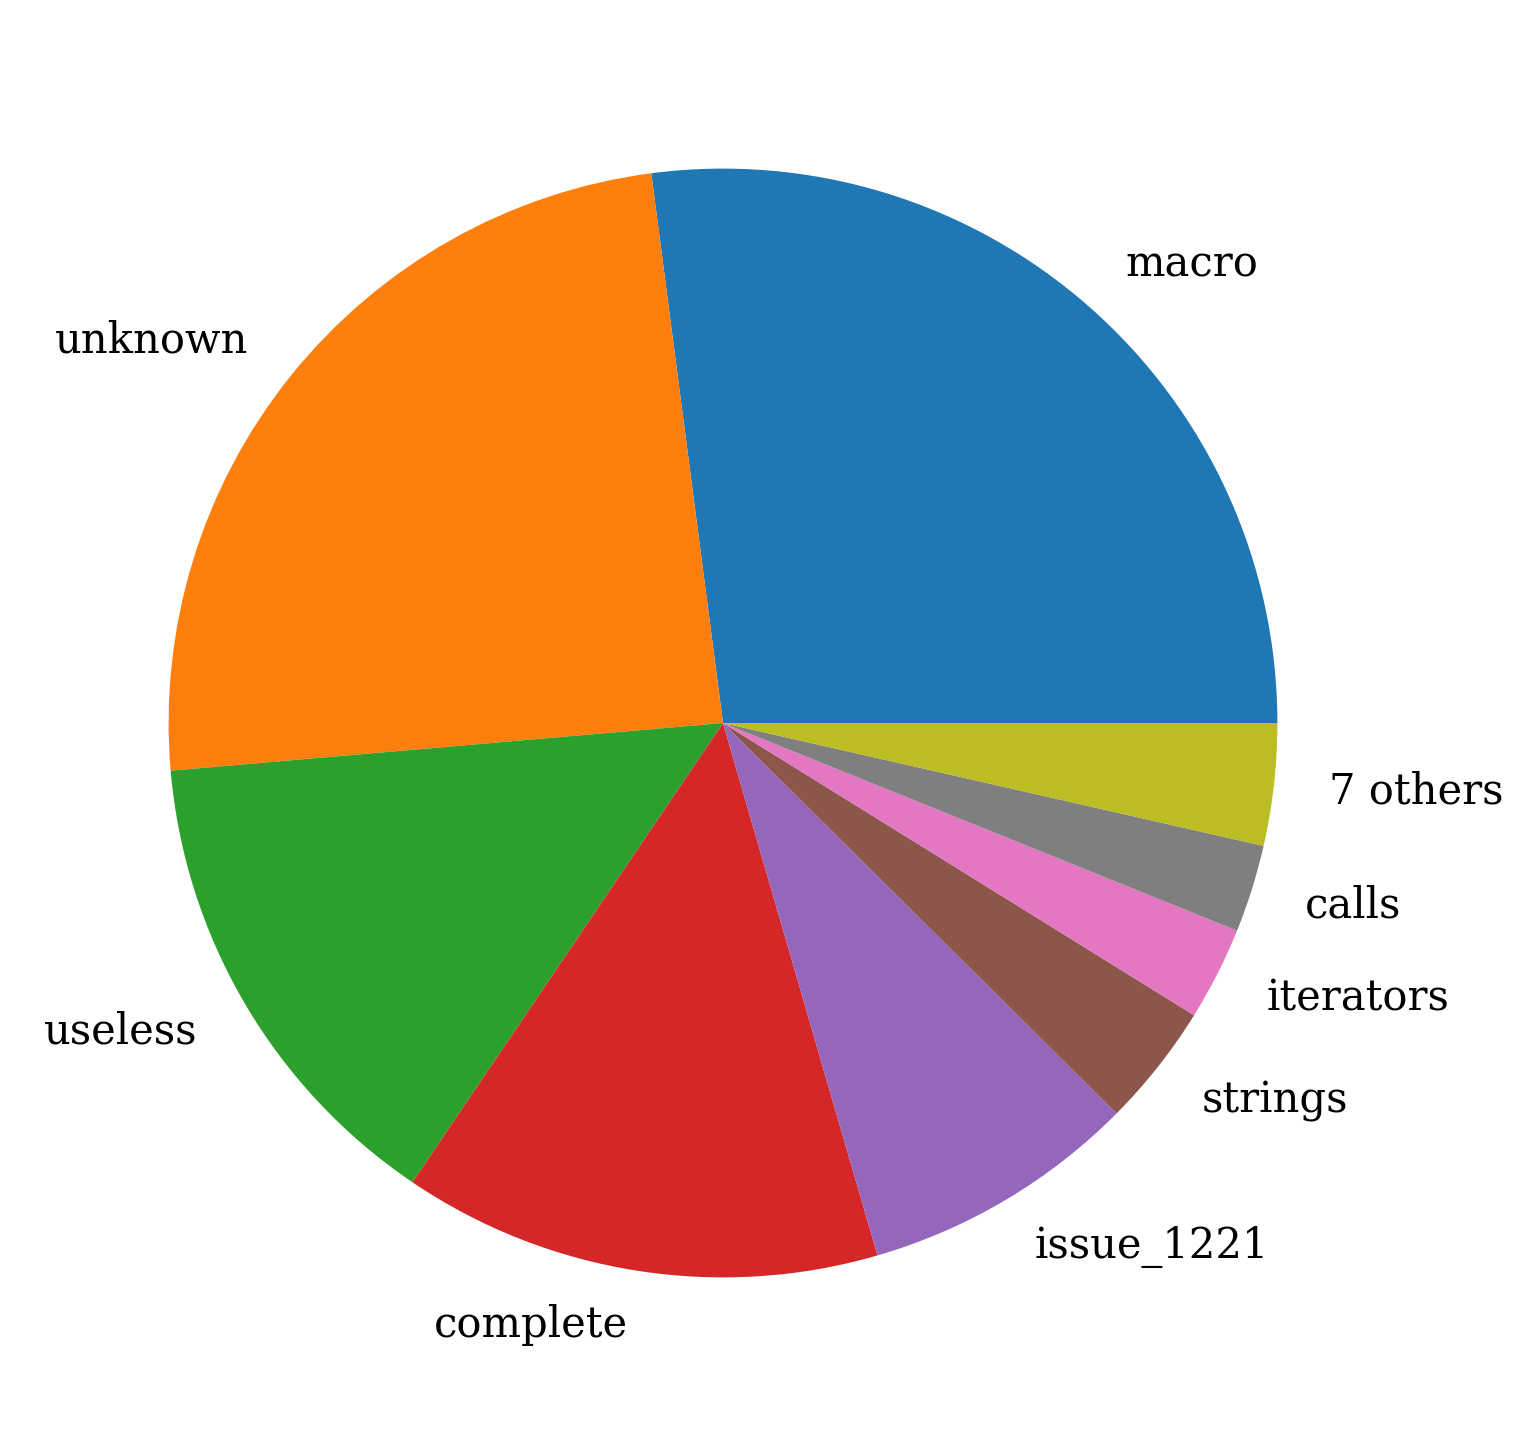

In [19]:
# don't label axes
cut_off_after_top(8, progress_tally).plot(
	kind='pie',
	y='count', ylabel='',
	figsize=(8, 6),
	legend=False,
	#startangle=90, counterclock=False,
)
plt.show()

In [20]:
macro_counts = sum_counts(all_calls, ['macro']).copy()
for (macro, count) in macro_counts.values[:20]:
	print(f"{count}x {macro}")

45505472x 
8403994x serde_derive::Deserialize
4020577x quote::quote
4019790x core::fmt::macros::Debug
2145961x core::clone::Clone
2130288x serde_derive::Serialize
1970558x alloc::macros::format
1270583x core::cmp::PartialEq
1129711x prost_derive::Message
1125126x core::macros::write
834400x core::default::Default
563725x alloc::macros::vec
471732x tracing::macros::trace
468446x clap_derive::Parser
452081x schemars_derive::JsonSchema
449097x tracing::macros::debug
357133x bitflags::bitflags
350308x log::macros::debug
325344x std::macros::println
320121x std::macros::panic


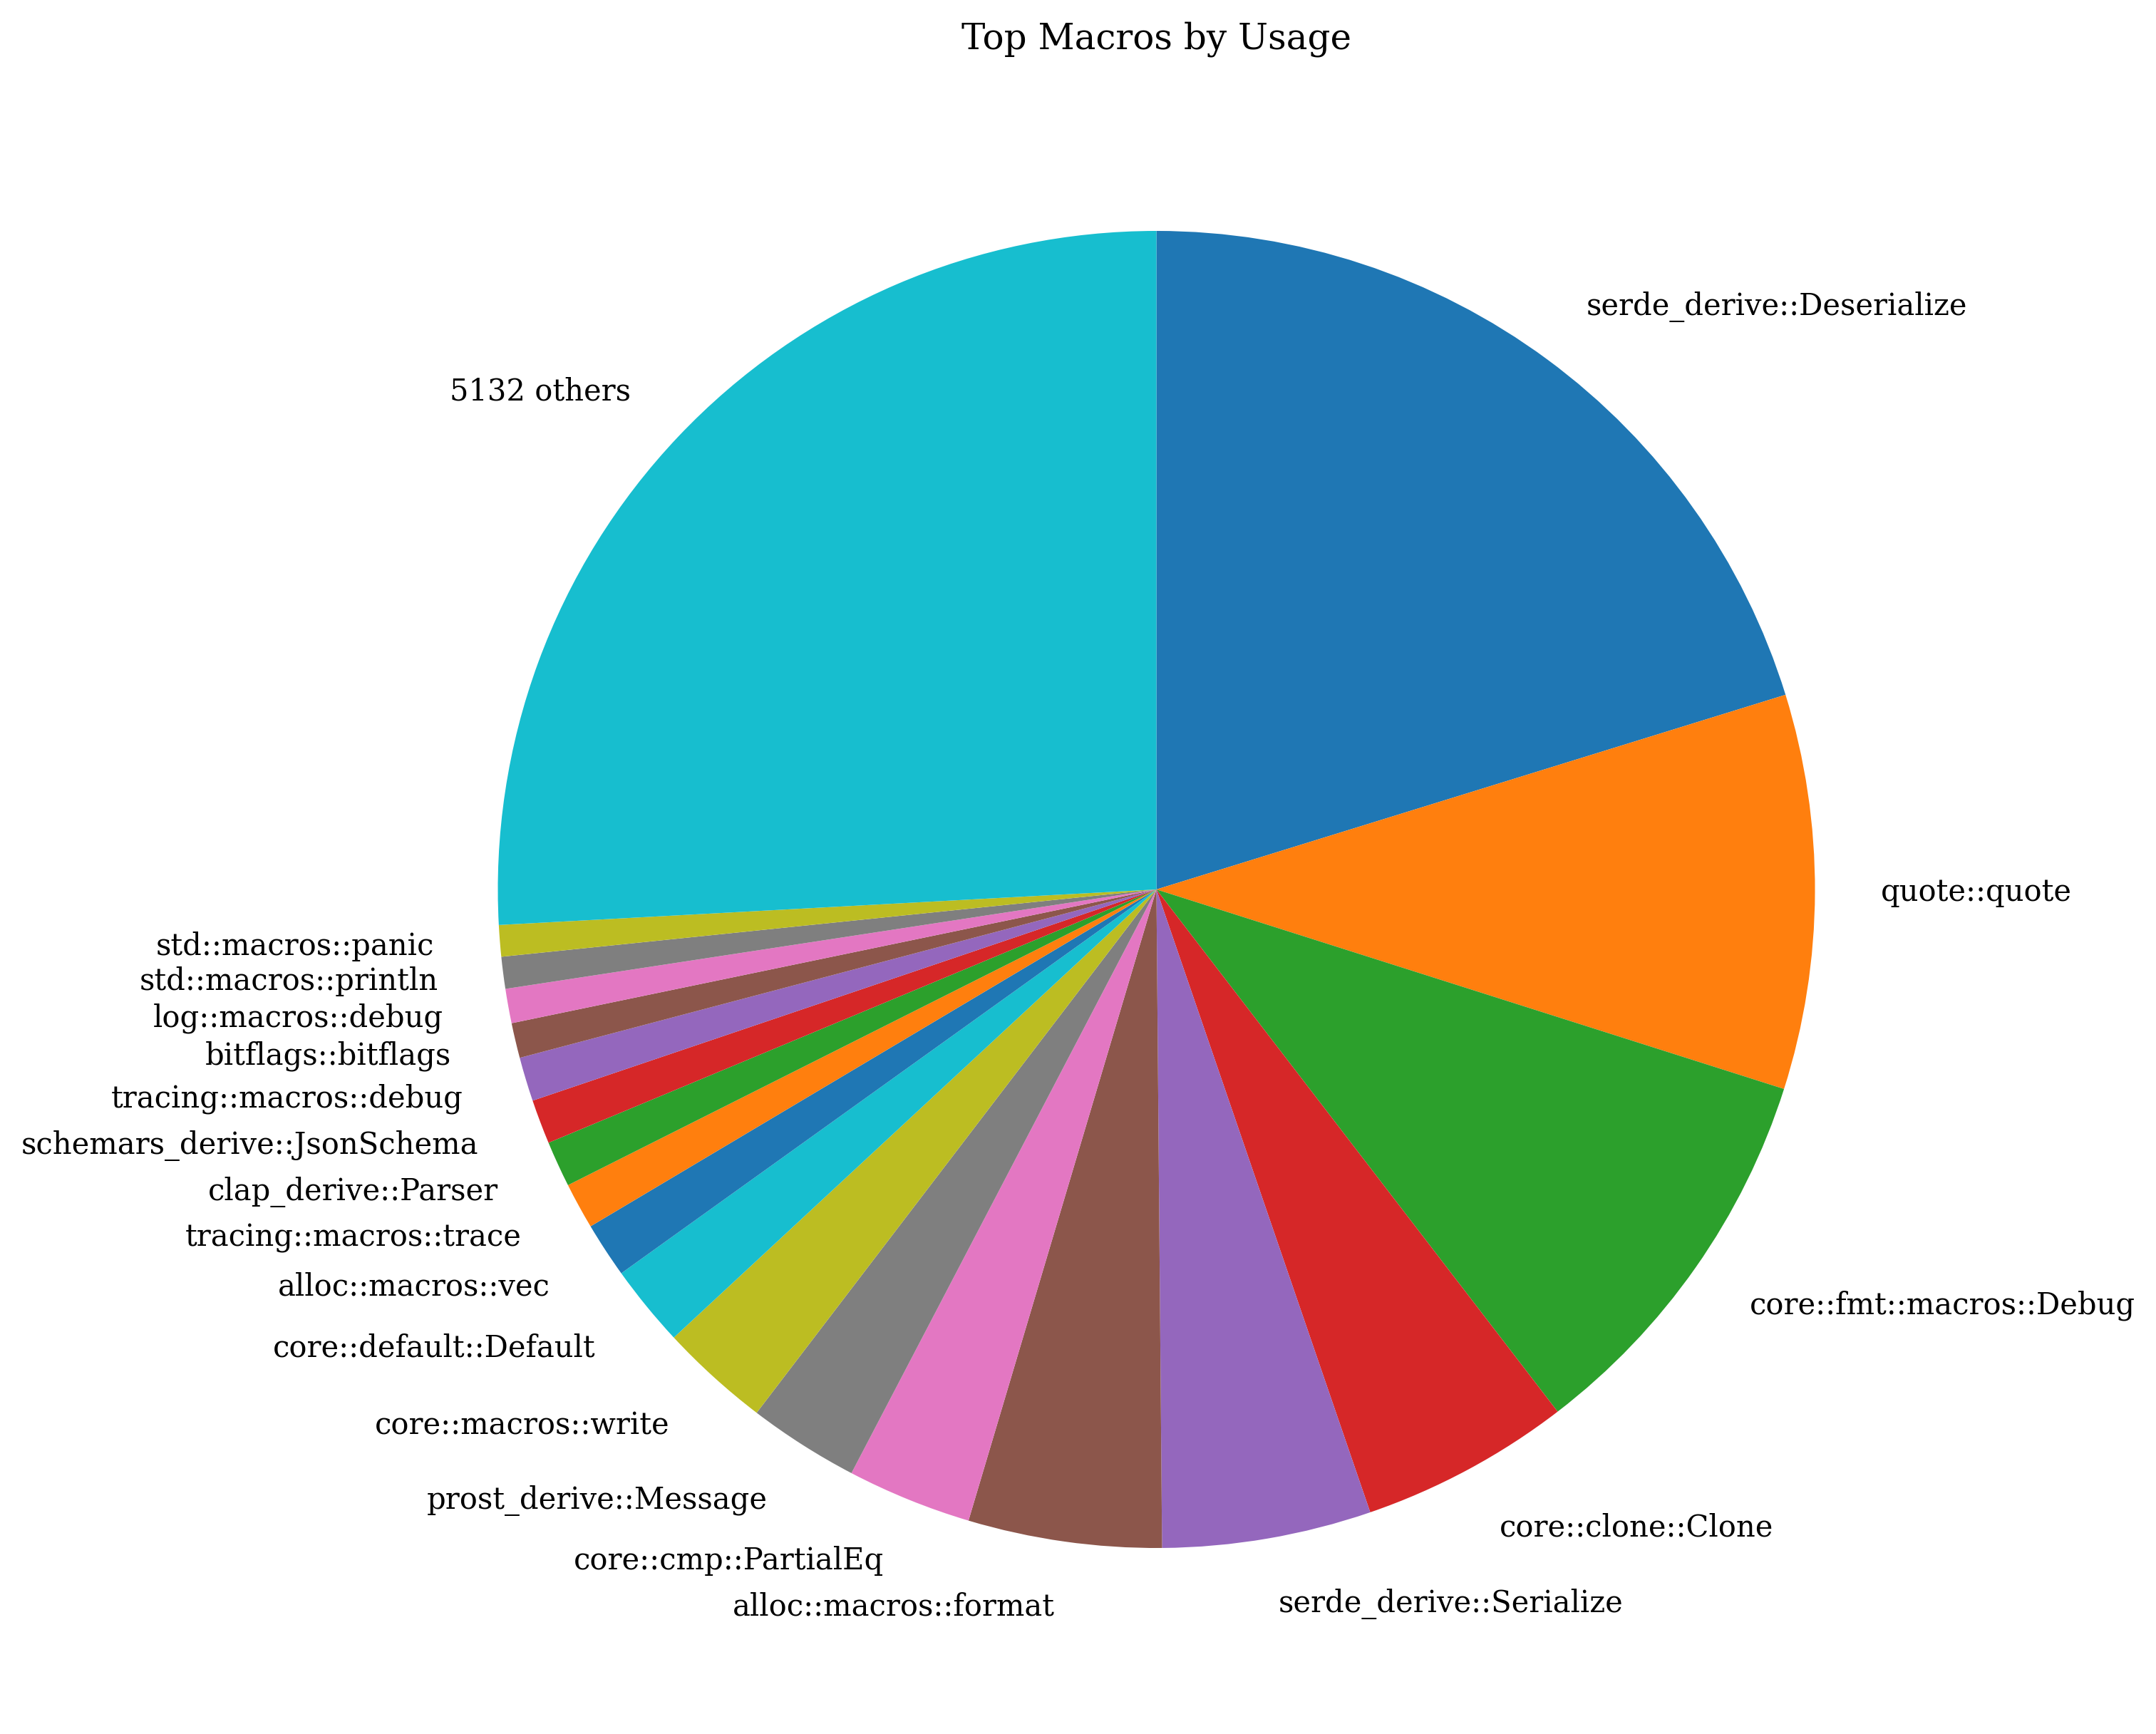

In [21]:
top_macro_counts = macro_counts.copy()
top_macro_counts.set_index('macro', inplace=True)
top_macro_counts.drop([""], inplace=True)

cut_off_after_top(19, top_macro_counts).plot(
	kind='pie',
	y='count', ylabel='',
	figsize=(12, 10),
	legend=False,
	startangle=90, counterclock=False,
	title="Top Macros by Usage"
)
plt.show()

In [22]:
def compute_totals(cumulative: pd.DataFrame):
	sums = cumulative['count'].cumsum()
	total = sums.iloc[-1]
	cumulative['total'] = sums / total

cumulative_counts = sum_counts(all_calls, ['target', 'receiver']).copy()
compute_totals(cumulative_counts)

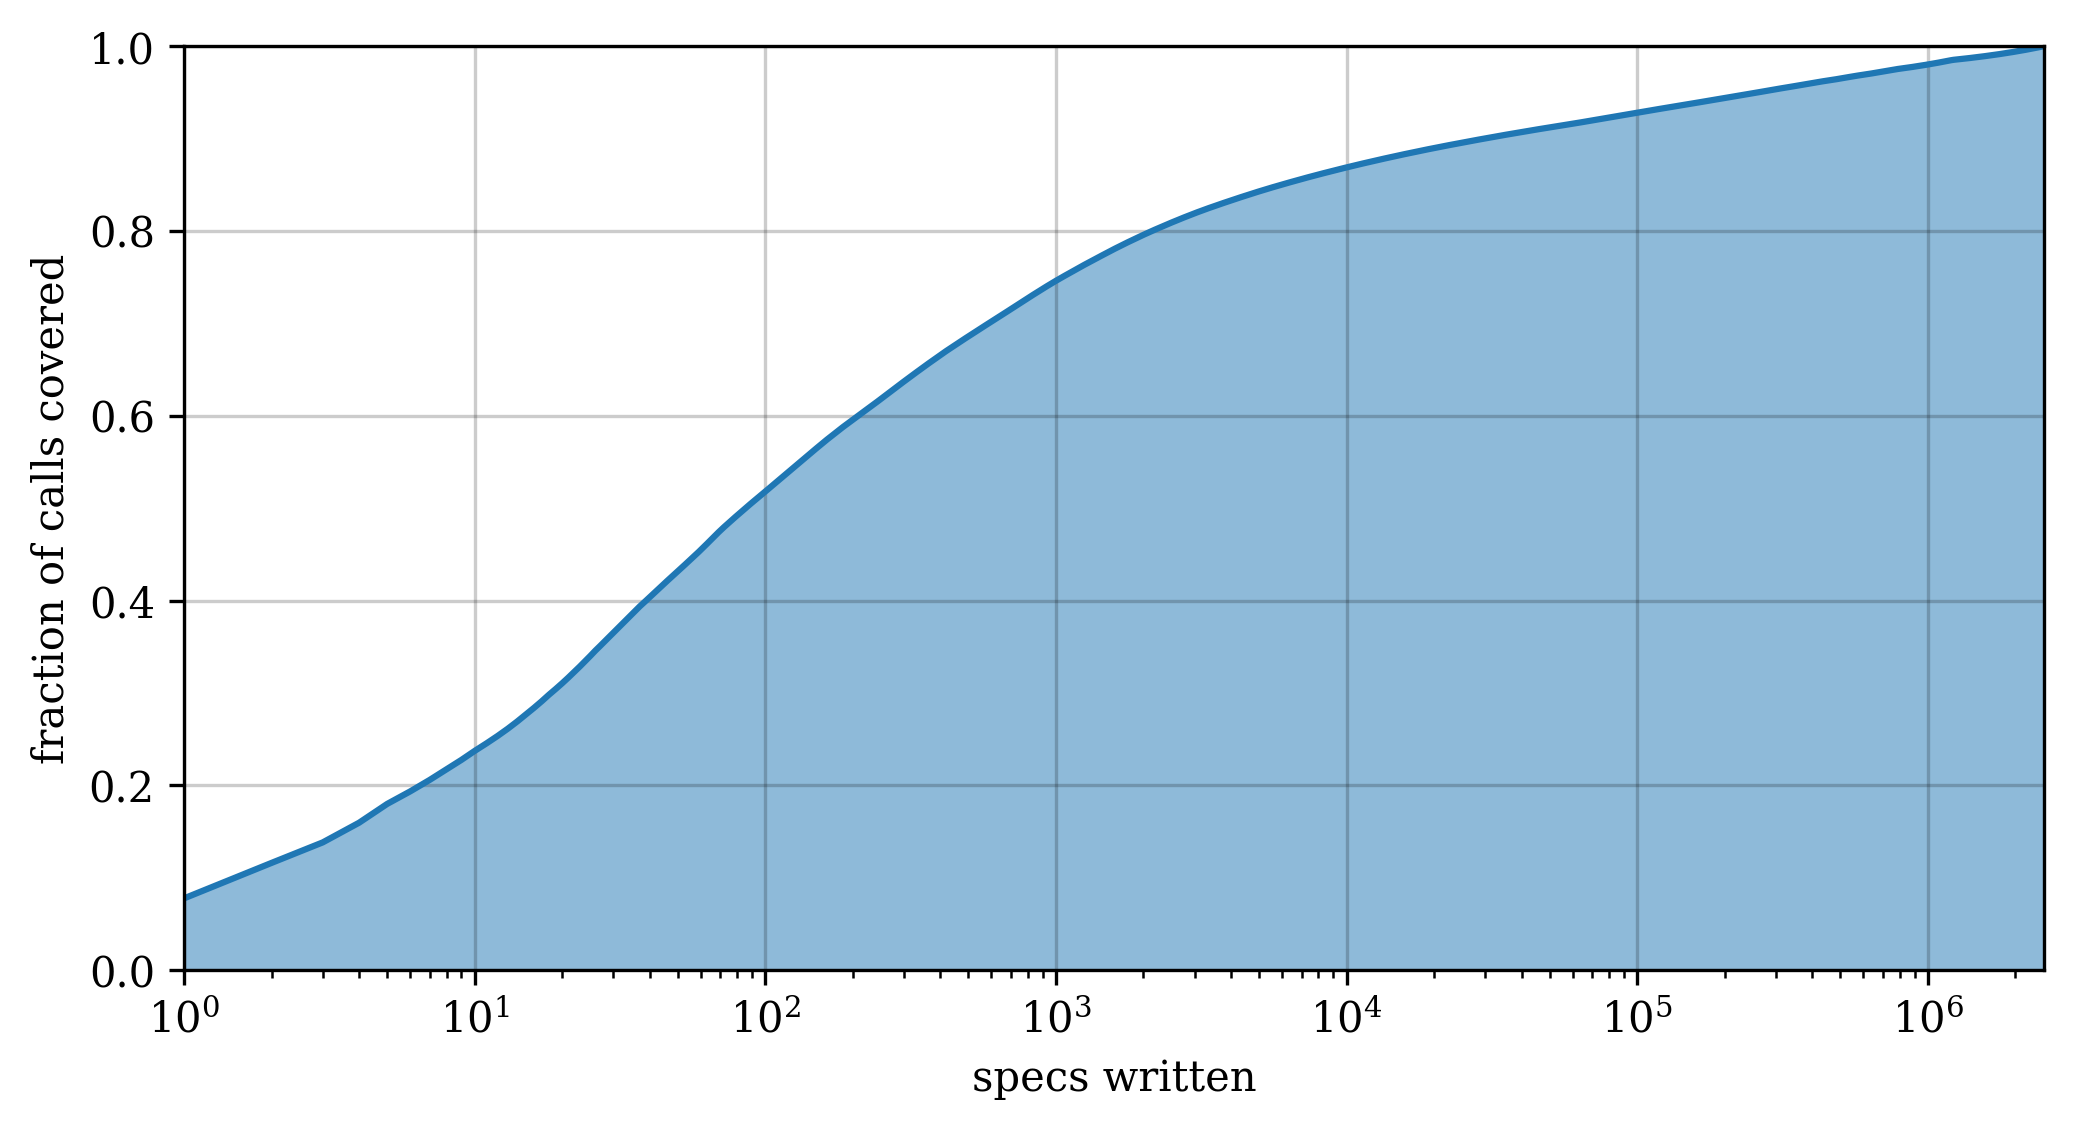

In [23]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.grid(color=(0, 0, 0), alpha=0.2)
ax.plot(cumulative_counts.index, cumulative_counts["total"])
ax.fill_between(cumulative_counts.index, cumulative_counts["total"], alpha=0.5)
plt.xlim(1, cumulative_counts.index.max())
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel("fraction of calls covered")
plt.xlabel("specs written")
plt.show()

In [24]:
counts = all_calls["count"]

def print_details(mask):
	masked = counts[mask]
	print(f"Calls: {masked.count()} / {counts.count()}")
	print(f"Occurrences: {masked.sum()} / {counts.sum()}")

print(f"< 10:")
print_details(counts < 10)
print()
print(f"> 1000:")
print_details(counts > 1000)

< 10:
Calls: 14932502 / 16101123
Occurrences: 29065492 / 87060395

> 1000:
Calls: 4445 / 16101123
Occurrences: 10992872 / 87060395


In [25]:
by_target = sum_counts(all_calls, ['target', 'target_crate'])
by_target

,target,target_crate,count
0,core::cmp::PartialEq::eq,core,5122320
1,core::ops::deref::Deref::deref,core,4161020
2,core::clone::Clone::clone,core,3502722
3,core::ops::try_trait::Try::branch,core,3457142
4,core::ops::try_trait::FromResidual::from_residual,core,3457138
5,core::fmt::Formatter::write_str,core,3416666
6,core::default::Default::default,core,1900443
7,core::fmt::Arguments::new_v1,core,1851757
8,core::fmt::ArgumentV1::new_display,core,1774675
9,quote::__private::push_ident,quote,1180899


In [26]:
cumulative_by_target = by_target.copy()
compute_totals(cumulative_by_target)

In [27]:
majority_by_target = len(cumulative_by_target[cumulative_by_target["total"] < 0.5]) + 1
print(majority_by_target, len(cumulative_by_target), 100 * majority_by_target / len(cumulative_by_target))
majority_by_call = len(cumulative_counts[cumulative_counts["total"] < 0.5]) + 1
print(majority_by_call, len(cumulative_counts), 100 * majority_by_call / len(cumulative_counts))

27 446378 0.006048685195058896
87 2511767 0.0034636970706279683


In [28]:
top_usage_counts = by_target.copy()
top_usage_counts.set_index('target', inplace=True)
top_usage_counts = cut_off_after_top(27, top_usage_counts)
top_usage_counts

,target_crate,count
target,,
core::cmp::PartialEq::eq,core,5122320
core::ops::deref::Deref::deref,core,4161020
core::clone::Clone::clone,core,3502722
core::ops::try_trait::Try::branch,core,3457142
core::ops::try_trait::FromResidual::from_residual,core,3457138
core::fmt::Formatter::write_str,core,3416666
core::default::Default::default,core,1900443
core::fmt::Arguments::new_v1,core,1851757
core::fmt::ArgumentV1::new_display,core,1774675


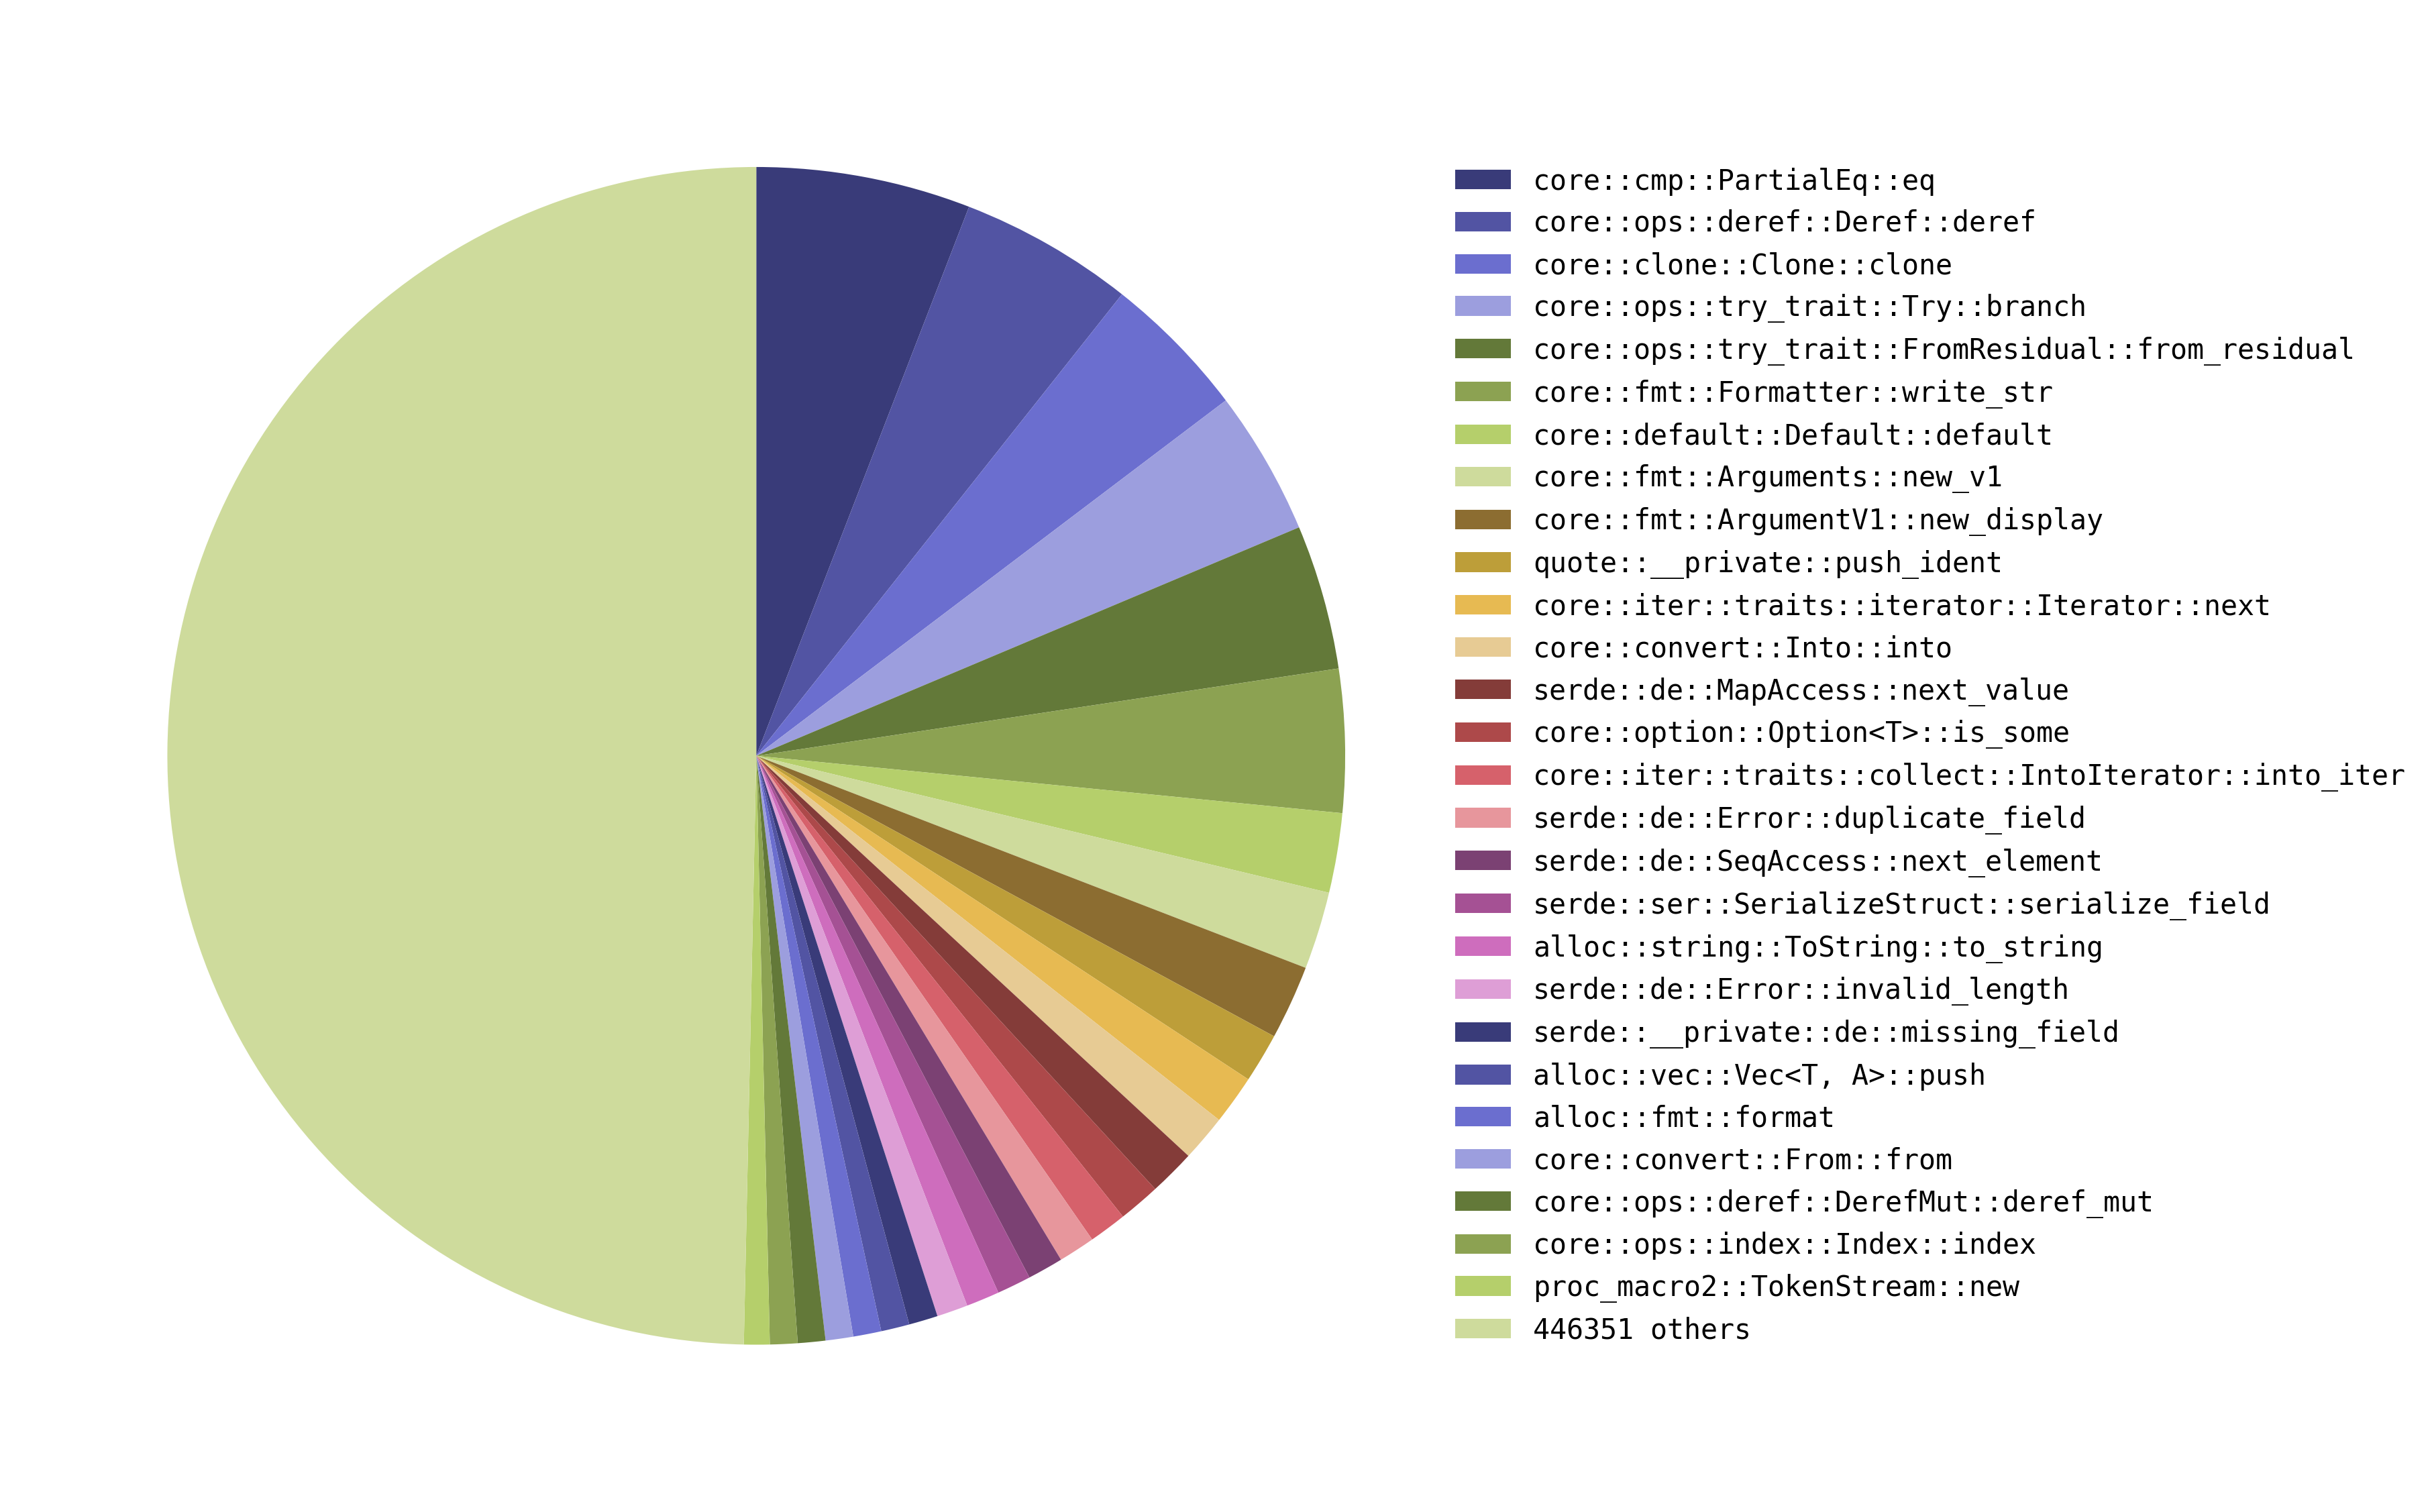

In [29]:

fig, ax = plt.subplots(figsize=(17, 9.5))
#colors = plt.cm.get_cmap('twilight')(np.linspace(0, 1, 29))
colors = plt.cm.get_cmap('tab20b').colors
ax.pie(top_usage_counts['count'], startangle=90, counterclock=False, rotatelabels=False, colors=colors)
fig.legend(top_usage_counts.index, loc="center right", prop=monospace, frameon=False)
fig.show()

In [30]:
# print full list of most popular targets in a single crate, for exporting

crate_filter = "core"
filtered = by_target[by_target['target_crate'] == crate_filter].reset_index(names='global_rank')
for i in range(min(100_000, len(filtered))):
	row = filtered.loc[i]
	print(f"{row['target']} - #{i + 1} (#{row['global_rank'] + 1} globally, {row['count']}x)")

core::cmp::PartialEq::eq - #1 (#1 globally, 5122320x)
core::ops::deref::Deref::deref - #2 (#2 globally, 4161020x)
core::clone::Clone::clone - #3 (#3 globally, 3502722x)
core::ops::try_trait::Try::branch - #4 (#4 globally, 3457142x)
core::ops::try_trait::FromResidual::from_residual - #5 (#5 globally, 3457138x)
core::fmt::Formatter::write_str - #6 (#6 globally, 3416666x)
core::default::Default::default - #7 (#7 globally, 1900443x)
core::fmt::Arguments::new_v1 - #8 (#8 globally, 1851757x)
core::fmt::ArgumentV1::new_display - #9 (#9 globally, 1774675x)
core::iter::traits::iterator::Iterator::next - #10 (#11 globally, 1177558x)
core::convert::Into::into - #11 (#12 globally, 1112335x)
core::option::Option<T>::is_some - #12 (#14 globally, 998312x)
core::iter::traits::collect::IntoIterator::into_iter - #13 (#15 globally, 903477x)
core::convert::From::from - #14 (#24 globally, 659319x)
core::ops::deref::DerefMut::deref_mut - #15 (#25 globally, 659261x)
core::ops::index::Index::index - #16 (#26 

In [31]:
by_crate = sum_counts(all_calls, ['target_crate']).set_index('target_crate')
by_crate

,count
target_crate,
core,53860887
serde,7596756
alloc,5584314
quote,3728109
std,1791127
clap,1425205
tracing_core,1180971
proc_macro2,764877
log,641517


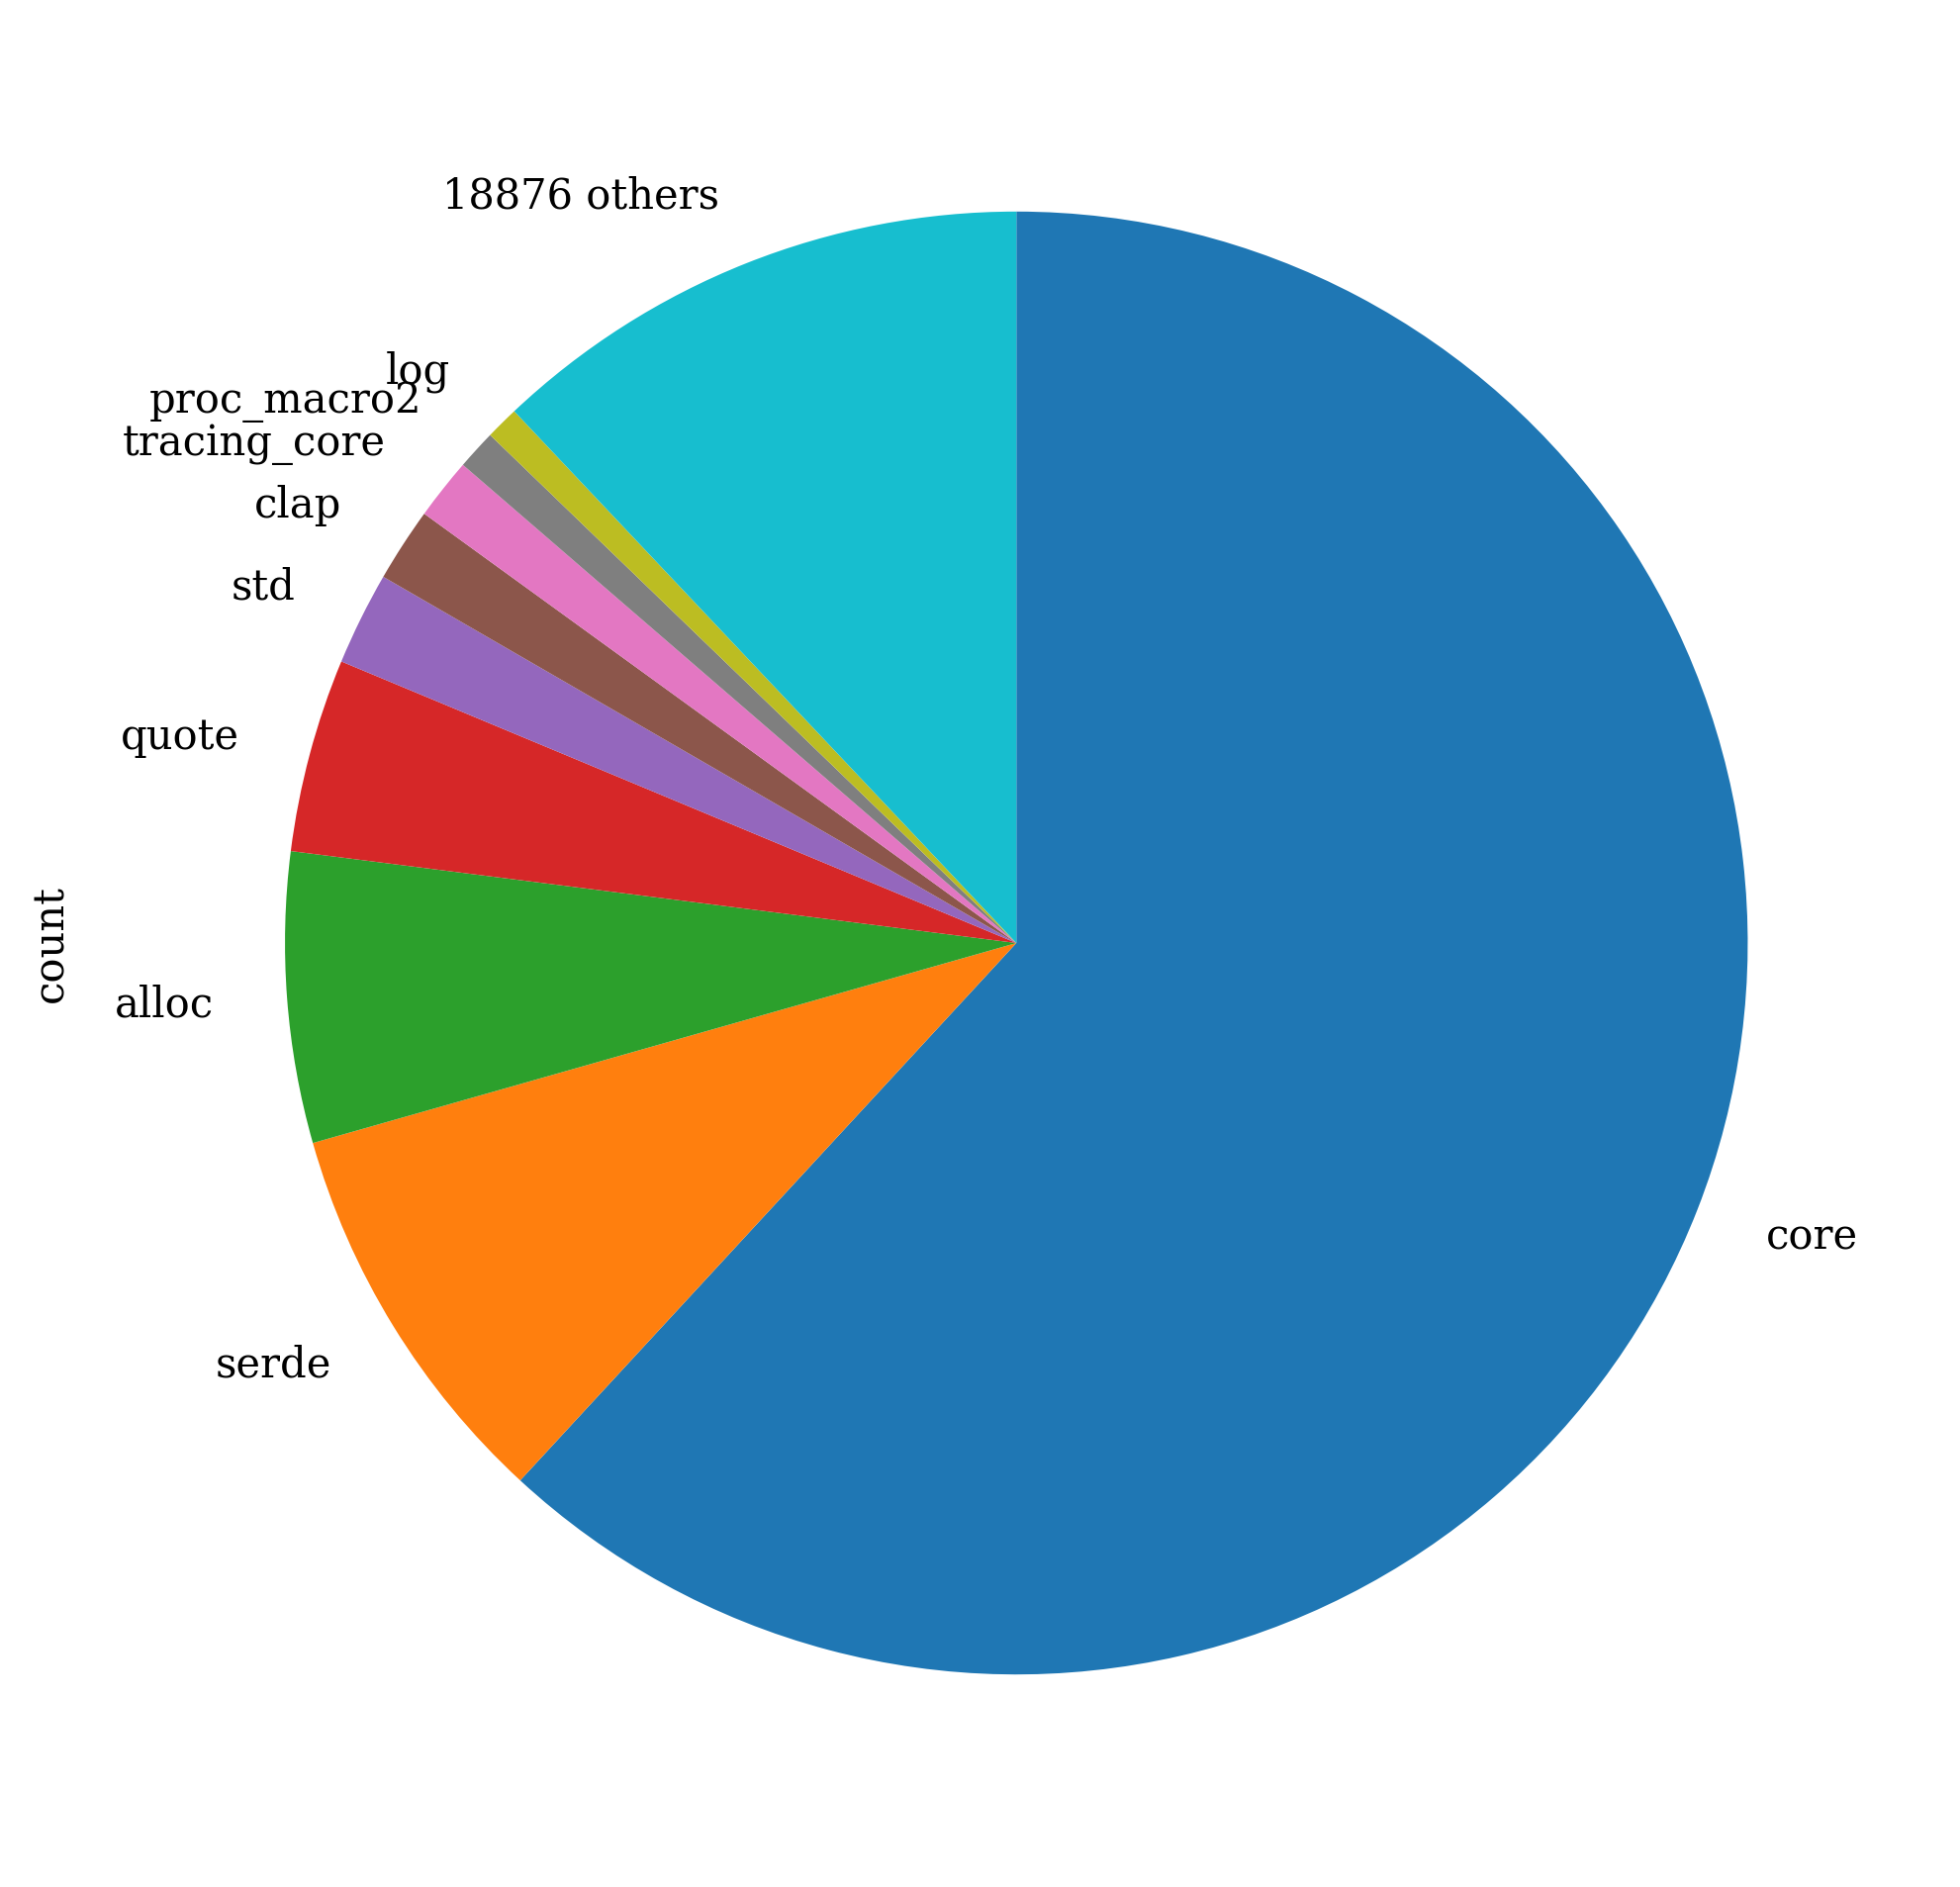

In [32]:
cut_off_after_top(9, by_crate).plot(
	kind='pie',
	y='count',
	legend=False,
	startangle=90, counterclock=False
)
plt.show()